In [69]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyart
import glob
import matplotlib.patheffects as path_effects
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
import radlib
import os
import h5py
import matplotlib.dates as mdates
from scipy.ndimage import gaussian_filter1d
from cartopy.feature import NaturalEarthFeature
os.environ["library_metranet_path"] = "/store_new/mch/msrad/idl/lib/radlib4/" # needed for pyradlib
os.environ["METRANETLIB_PATH"] = "/store_new/mch/msrad/idl/lib/radlib4/" # needed for pyart_mch



In [73]:
# Defining valid time and elevation scan

valid_time1 = '1400 UTC'
valid_time2 = '14:00'
valid_time3 = '1400'
elevation_scan = '3'

In [75]:
# Data Imports, processing, norming, etc.

# Transform function for dealiased velocity
def transform_from_digital(mydata, nyquist):
    myfinaldata = (mydata * 1.0 - 128) * nyquist / 127
    myfinaldata[mydata == 0] = np.nan
    return myfinaldata


# Convert polar coordinates (range, azimuth) to geographic coordinates (lat/lon)
def radar_to_latlon(radar_lat, radar_lon, ranges, azimuths):
    R = 6371.0  # Earth radius in kilometers
    azimuths_rad = np.radians(azimuths)
    latitudes = np.zeros((len(azimuths), len(ranges)))
    longitudes = np.zeros((len(azimuths), len(ranges)))

    for i, az in enumerate(azimuths_rad):
        latitudes[i, :] = radar_lat + (ranges / R) * np.cos(az) * (180.0 / np.pi)
        longitudes[i, :] = radar_lon + (ranges / R) * np.sin(az) * (180.0 / np.pi) / np.cos(np.radians(radar_lat))

    return latitudes, longitudes



# Radar location (Lema radar, Switzerland)
radar_lat = 46.0401
radar_lon = 8.8334
radar_alt = 1620

# Coordinates of cities
locarno_lat = 46.1700
locarno_lon = 8.7996
lugano_lat = 46.0037
lugano_lon = 8.9511

# Load radar data
path = '/scratch/mch/fackerma/orders/case_130721'
file = glob.glob(path + '/MLL/MLL21194' + valid_time3 + '0U.00' + elevation_scan) # ML data 
file2 = glob.glob(path +'/DVL/srn/data/tmp/mof/DVL/DVL21194' + valid_time3 + '7L.80' + elevation_scan) # Dealiased velocity
file3 = glob.glob(path +'/HZC/HZC21194' + valid_time3 + 'VL.801') # Freezing level height composite
file4 = glob.glob(path +'/VAL/VAL21194' + valid_time3 + '7U.019') # Vertical wind profile above radar
file5 = glob.glob(path +'/BZC/BZC21194' + valid_time3 + 'VL.845') # POH
file6 = glob.glob(path +'/MZC/MZC21194' + valid_time3 + 'VL.850') # MESH
file7 = glob.glob(path +'/TRTC/CZC21194' + valid_time3 + '0T.rdt') # Thunderstorm radar tracking; or .rdt .trt
file8 = glob.glob(path +'/CZC/CZC21194' + valid_time3 + 'VL.801') # Reflectivity composite
file9 = glob.glob(path +'/LZC/LZC21194' + valid_time3 + 'VL.801') # VIL composite
file10 = glob.glob(path +'/EZC/EZC21194' + valid_time3 + 'VL.820') # Echotops composite: 815, 820, 845, 850
file11 = glob.glob(path +'/OZC/OZC21194' + valid_time3 + 'VL.830') # CAPPI composite, ranging from 810 to 980 in steps of 10
file12 = glob.glob(path + '/dARC/ARC211940000FF.1440') # daily bias corrected rain accumulation
file13 = glob.glob(path + '/dBZC/BZC211942400VL.845') # daily POH
file14 = glob.glob(path + '/dRZC/RZC211942400VL.801') # daily Rain Rate
file15 = glob.glob(path + '/dCZC/CZC211942400VL.801') # daily Max Echo


# Read the data for the plots
data = pyart.aux_io.read_metranet(file[0], reader='python')
velocity = data.get_field(0, 'velocity').data
reflectivity = data.get_field(0, 'reflectivity').data

dv_data = pyart.aux_io.read_file_py(file2[0], physic_value=False)
dv_digital = dv_data.data
dv_header = dv_data.header
nyq = float(dv_header['nyquist'])
dv_velocity = transform_from_digital(dv_digital, nyq)

hzc_data = radlib.read_file(file3[0],physic_value=True)
hzc=hzc_data.data

dARC_data = radlib.read_file(file12[0],physic_value=True)
dARC=dARC_data.data

dBZC_data = radlib.read_file(file13[0],physic_value=True)
dBZC=dBZC_data.data

dRZC_data = radlib.read_file(file14[0],physic_value=True)
dRZC=dRZC_data.data

dCZC_data = radlib.read_file(file15[0],physic_value=True)
dCZC=dCZC_data.data

diff_reflectivity = data.get_field(0, 'differential_reflectivity').data

diff_phase = data.get_field(0, 'uncorrected_differential_phase').data

cc_ratio = data.get_field(0, 'uncorrected_cross_correlation_ratio').data

mzc_data = radlib.read_file(file6[0],physic_value=True)
mzc=mzc_data.data

bzc_data = radlib.read_file(file5[0],physic_value=True)
bzc=bzc_data.data

specw = data.get_field(0, 'spectrum_width').data

czc_data = radlib.read_file(file8[0],physic_value=True)
czc=czc_data.data

lzc_data = radlib.read_file(file9[0],physic_value=True)
lzc=lzc_data.data

ezc_data = radlib.read_file(file10[0],physic_value=True)
ezc=ezc_data.data

ozc_data = radlib.read_file(file11[0],physic_value=True)
ozc=ozc_data.data

#trtc_data = radlib.read_file(file7[0],physic_value=True)
#trtc=trtc_data.data
# Define radar resolution and grid

# Convert echotop18 from km to meters
ezc_m = ezc * 1000
# Compute the wind gust estimator 'wge' (Trefalt 2017)
wge = np.sqrt((-3.1 * 10**-6 * (ezc**2)) + (20.6 * lzc))


resolution = 0.5
range_max = reflectivity.shape[1] * resolution
azimuths = np.linspace(0, 360, reflectivity.shape[0])
ranges = np.arange(0, range_max, resolution)

# Assuming the differential phase data is in 'diff_phase' (in degrees)
# and you have 'ranges' (in kilometers)
# Apply a smoothing function to the differential phase data (optional, for noise reduction)
# You can adjust the smoothing factor sigma depending on how smooth the data should be
smoothed_diff_phase = gaussian_filter1d(diff_phase, sigma=2, axis=1)  # Smoothing along range dimension
# Calculate the Kdp (specific differential phase shift) by taking the numerical derivative
# of the differential phase along the range axis (axis=1 in this case)
# Derivative in the radial direction
Kdp = np.gradient(smoothed_diff_phase, ranges, axis=1)
# Convert Kdp to degrees per kilometer (already implicitly done by np.gradient and the ranges in km)
# Kdp is typically in degrees/km


# Read the vertical wind profile data (VAD) above the radar
#vad_data = pyart.aux_io.read_file_py(path +'/VAD/VAD19166' + valid_time3 + '7U.020', physic_value=False)
# Extract fields from vad_data as required (example: wind_speed and wind_direction)
#wind_speed = vad_data.get_field(0, 'wind_speed').data  # Replace 'wind_speed' with the actual field name
#wind_direction = vad_data.get_field(0, 'wind_direction').data  # Replace 'wind_direction' with the actual field name
#altitude = vad_data.get_field(0, 'altitude').data  # Altitudes of the wind profile
# Now you have wind speed, wind direction, and altitude profiles for further analysis or plotting






# Transform radar polar coordinates to lat/lon
lats, lons = radar_to_latlon(radar_lat, radar_lon, ranges, azimuths)

# Define the Swiss grid (values based on metadata)
chx = np.arange(255000, 255000 + 710 * 1000 + 1, 1000)
chy = sorted(np.arange(-160000, -160000 + 640 * 1000 + 1, 1000), reverse=True)
X, Y = np.meshgrid(chx, chy)
# Initialize transformer for Swiss grid to WGS84 (EPSG:21781 to EPSG:4326)
transformer = Transformer.from_crs(21781, 4326, always_xy=True)
# Convert Swiss grid coordinates to lat/lon
clons, clats = transformer.transform(X, Y)


# Define color steps for Reflectivity and Velocity/Dealiased Velocity
czc_levels = np.arange(0, 60, 5)  # Steps of 2 for Reflectivity
reflectivity_levels = np.arange(0, 60, 5)  # Steps of 2 for Reflectivity
velocity_levels = np.arange(-25, 26, 5)  # Steps of 1 for Velocity and Dealiased Velocity
hzc_levels = np.arange(1, 10, 1)
diff_reflectivity_levels = np.arange(-7,9,2)
diff_phase_levels = np.arange(-70,90,20)
cc_ratio_levels = np.arange(0.7,1,0.05)
mzc_levels = np.arange(0,5.5,0.5)
bzc_levels = np.arange(0,101,10)
specw_levels = np.arange(0,7,1)
Kdp_levels = np.arange(0,5.5,0.5)
lzc_levels = np.arange(2.5,25,2.5)
ezc_levels = np.arange(2,16,2)
wge_levels = np.arange(2,20,2)
# Create boundary norms
czc_norm = BoundaryNorm(boundaries=czc_levels, ncolors=plt.cm.inferno.N, clip=True)
reflectivity_norm = BoundaryNorm(boundaries=reflectivity_levels, ncolors=plt.cm.inferno.N, clip=True)
velocity_norm = BoundaryNorm(boundaries=velocity_levels, ncolors=256, clip=True)
hzc_norm = BoundaryNorm(boundaries=hzc_levels, ncolors=256, clip=True)
diff_reflectivity_norm = BoundaryNorm(boundaries=diff_reflectivity_levels, ncolors=256, clip=True)
diff_phase_norm = BoundaryNorm(boundaries=diff_phase_levels, ncolors=256, clip=True)
cc_ratio_norm = BoundaryNorm(boundaries=cc_ratio_levels, ncolors=256, clip=True)
mzc_norm = BoundaryNorm(boundaries=mzc_levels, ncolors=256, clip=True)
bzc_norm = BoundaryNorm(boundaries=bzc_levels, ncolors=256, clip=True)
specw_norm = BoundaryNorm(boundaries=specw_levels, ncolors=256, clip=True)
Kdp_norm = BoundaryNorm(boundaries=Kdp_levels, ncolors=256, clip=True)
lzc_norm = BoundaryNorm(boundaries=lzc_levels, ncolors=256, clip=True)
ezc_norm = BoundaryNorm(boundaries=ezc_levels, ncolors=256, clip=True)
wge_norm = BoundaryNorm(boundaries=wge_levels, ncolors=256, clip=True)

# Load the station data from the .txt file
station_data_path = '/users/fackerma/newproject1/case_150619_stations.csv'
stations_df = pd.read_csv(station_data_path)

# Convert time column to datetime for easier filtering
stations_df['time'] = pd.to_datetime(stations_df['time'], format='%Y%m%d%H%M')


py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
swap product table data ......
py_decoder DBG verb=0
py_decoder DBG verbl=0


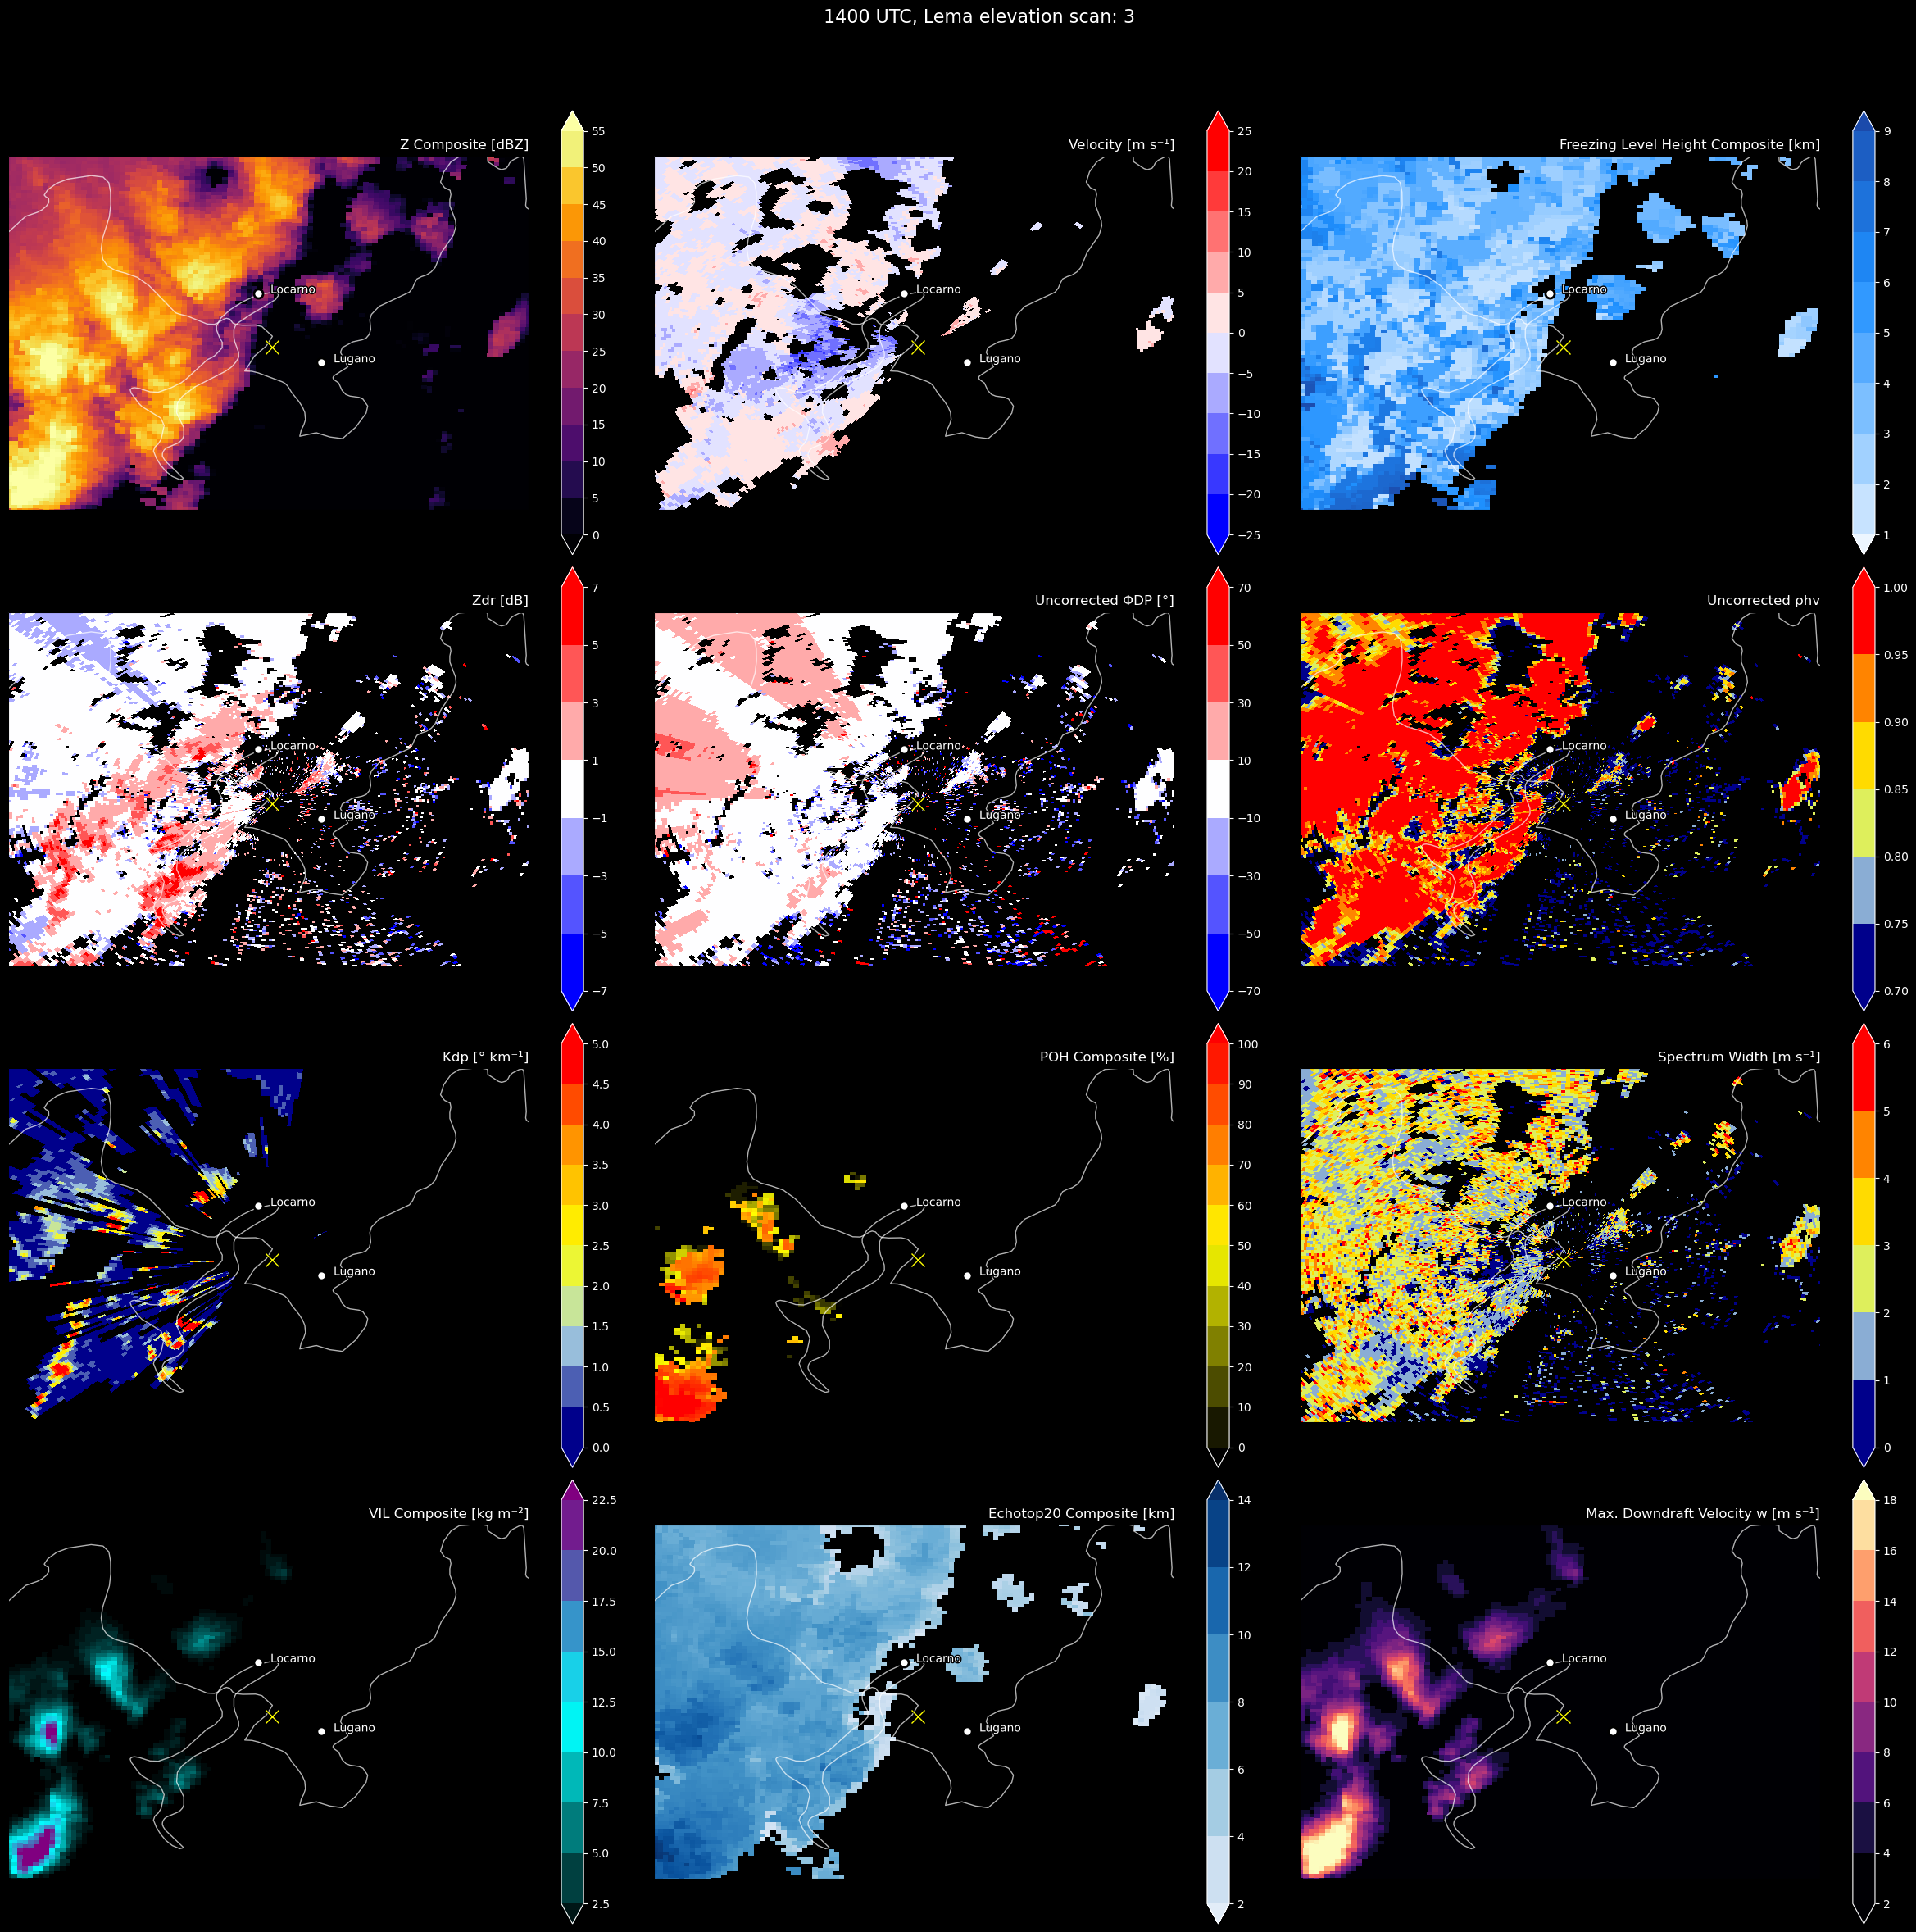

In [76]:
# Multi-variable plot

# Create figure with three subplots (Reflectivity, Velocity, and Dealiased Velocity)
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(24, 24), subplot_kw={'projection': ccrs.PlateCarree()})

# Set background to black for all subplots
for row in axs:  # axs is a 2D array, so iterate through rows
    for ax in row:  # Iterate through each subplot in the row
        fig.patch.set_facecolor('black')  # Set figure background
        ax.set_facecolor('black')  # Set axis background


# Plot Reflectivity composite
cmap_czc = plt.cm.inferno
cmap_czc.set_bad(color='grey')
p1 = axs[0,0].pcolormesh(clons, clats, czc, vmin=0, vmax=55, 
                   cmap=cmap_czc, transform=ccrs.PlateCarree())
# Add a colorbar
cbar1 = plt.colorbar(p1, ax=axs[0,0], extend='both', cmap=cmap_czc, norm=czc_norm, boundaries=czc_levels, ticks=czc_levels
                     )
cbar1.outline.set_edgecolor('white')
cbar1.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color='white')
axs[0,0].set_title('Z Composite [dBZ]', color='white', loc='right')


# Plot Dealiased Velocity
cmap_velocity = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white", "red"], N=256)
cmap_velocity.set_bad(color='black')
p2 = axs[0,1].pcolormesh(lons, lats, dv_velocity, cmap=cmap_velocity, norm=velocity_norm, transform=ccrs.PlateCarree())
cbar2 = plt.colorbar(p2, ax=axs[0,1], cmap=cmap_velocity, extend='both', boundaries=velocity_levels, ticks=velocity_levels)
cbar2.outline.set_edgecolor('white')
cbar2.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar2.ax.axes, 'yticklabels'), color='white')
axs[0,1].set_title('Velocity [m s⁻¹]', color='white', loc='right')


# Plot Freezing level height
# Mask values of freezing level height that are 0 or lower
hzc_masked = np.ma.masked_less_equal(hzc, 0)
# Define a custom colormap, setting the under value (for masked/low values) to black
cmap_hzc = LinearSegmentedColormap.from_list("custom_cmap", ["white", "dodgerblue", "midnightblue"], N=256)
#cmap_hzc.set_under('black')  # Black for values 0 or lower
cmap_hzc.set_bad(color='black')  # Black for invalid data
# Plot the freezing level height with the masked values
p3 = axs[0,2].pcolormesh(clons, clats, hzc_masked, vmin=0, vmax=12, 
                         cmap=cmap_hzc, transform=ccrs.PlateCarree())
# Add a colorbar
cbar3 = plt.colorbar(p3, ax=axs[0,2], extend='both', cmap=cmap_hzc, boundaries=hzc_levels, ticks=hzc_levels)
cbar3.outline.set_edgecolor('white')
cbar3.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar3.ax.axes, 'yticklabels'), color='white')
axs[0,2].set_title('Freezing Level Height Composite [km]', color='white', loc='right')


# Plot Differential Reflectivity
cmap_diff_reflectivity = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white","red"], N=256)
cmap_diff_reflectivity.set_bad(color='black')
p4 = axs[1,0].pcolormesh(lons, lats, diff_reflectivity, cmap=cmap_diff_reflectivity, norm=diff_reflectivity_norm, 
                         transform=ccrs.PlateCarree())
cbar4 = plt.colorbar(p4, ax=axs[1,0], cmap=cmap_diff_reflectivity, extend='both', boundaries=diff_reflectivity_levels, ticks=diff_reflectivity_levels
                     )
cbar4.outline.set_edgecolor('white')
cbar4.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar4.ax.axes, 'yticklabels'), color='white')
axs[1,0].set_title('Zdr [dB]', color='white', loc='right')


# Plot Differential Phase
cmap_diff_phase = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white","red"], N=256)
cmap_diff_phase.set_bad(color='black')
p5 = axs[1,1].pcolormesh(lons, lats, diff_phase, cmap=cmap_diff_phase, norm=diff_phase_norm, 
                         transform=ccrs.PlateCarree())
cbar5 = plt.colorbar(p5, ax=axs[1,1], cmap=cmap_diff_phase, extend='both', boundaries=diff_phase_levels, ticks=diff_phase_levels
                     )
cbar5.outline.set_edgecolor('white')
cbar5.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar5.ax.axes, 'yticklabels'), color='white')
axs[1,1].set_title('Uncorrected ΦDP [°]', color='white', loc='right')


# Plot CC ratio
cmap_cc_ratio = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_cc_ratio.set_bad(color='black')
p6 = axs[1,2].pcolormesh(lons, lats, cc_ratio, cmap=cmap_cc_ratio, norm=cc_ratio_norm, 
                         transform=ccrs.PlateCarree())
cbar6 = plt.colorbar(p6, ax=axs[1,2], cmap=cmap_cc_ratio, extend='both', boundaries=cc_ratio_levels, ticks=cc_ratio_levels
                     )
cbar6.outline.set_edgecolor('white')
cbar6.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar6.ax.axes, 'yticklabels'), color='white')
axs[1,2].set_title('Uncorrected ρhv', color='white', loc='right')


# Plot Kdp
cmap_Kdp = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_Kdp.set_bad(color='black')
p7 = axs[2,0].pcolormesh(lons, lats, Kdp, norm=Kdp_norm,
                   cmap=cmap_Kdp, transform=ccrs.PlateCarree())
# Add a colorbar
cbar7 = plt.colorbar(p7, ax=axs[2,0], extend='both', cmap=cmap_Kdp, boundaries=Kdp_levels, ticks=Kdp_levels
                     )
cbar7.outline.set_edgecolor('white')
cbar7.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar7.ax.axes, 'yticklabels'), color='white')
axs[2,0].set_title('Kdp [° km⁻¹]', color='white', loc='right')


# Plot POH
cmap_bzc = LinearSegmentedColormap.from_list("custom_cmap", ["black","yellow", "red"], N=256)
cmap_bzc.set_bad(color='black')
p8 = axs[2,1].pcolormesh(clons, clats, bzc, 
                   cmap=cmap_bzc, transform=ccrs.PlateCarree())
# Add a colorbar
cbar8 = plt.colorbar(p8, ax=axs[2,1], extend='both', cmap=cmap_bzc, boundaries=bzc_levels, ticks=bzc_levels
                     )
cbar8.outline.set_edgecolor('white')
cbar8.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar8.ax.axes, 'yticklabels'), color='white')
axs[2,1].set_title('POH Composite [%]', color='white', loc='right')


# Plot Spectrum Width
cmap_specw = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_specw.set_bad(color='black')
p9 = axs[2,2].pcolormesh(lons, lats, specw, cmap=cmap_specw, norm=specw_norm, 
                         transform=ccrs.PlateCarree())
cbar9 = plt.colorbar(p9, ax=axs[2,2], cmap=cmap_specw, extend='both', boundaries=specw_levels, ticks=specw_levels
                     )
cbar9.outline.set_edgecolor('white')
cbar9.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar9.ax.axes, 'yticklabels'), color='white')
axs[2,2].set_title('Spectrum Width [m s⁻¹]', color='white', loc='right')

# Plot VIL composite
#lzc = np.ma.masked_less_equal(lzc, 0.1)
cmap_lzc = LinearSegmentedColormap.from_list("custom_cmap", ["black", "cyan", "purple"#, "red"
                                                             ], N=256)
cmap_lzc.set_bad(color='black')
p10 = axs[3,0].pcolormesh(clons, clats, lzc, vmin=1, vmax=22.5, 
                   cmap=cmap_lzc, transform=ccrs.PlateCarree())
# Add a colorbar
cbar10 = plt.colorbar(p10, ax=axs[3,0], extend='both', cmap=cmap_lzc, norm=lzc_norm, boundaries=lzc_levels, ticks=lzc_levels
                     )
cbar10.outline.set_edgecolor('white')
cbar10.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar10.ax.axes, 'yticklabels'), color='white')
axs[3,0].set_title('VIL Composite [kg m⁻²]', color='white', loc='right')

# Plot Echotop 20 composite
# Set a mask
ezc = np.ma.masked_less_equal(ezc, 0)
cmap_ezc = plt.cm.Blues
cmap_ezc.set_bad(color='black')
p11 = axs[3,1].pcolormesh(clons, clats, ezc, vmin=0, vmax=14,  
                   cmap=cmap_ezc, transform=ccrs.PlateCarree())
# Add a colorbar
cbar11 = plt.colorbar(p11, ax=axs[3,1], extend='both', cmap=cmap_ezc, norm=ezc_norm, boundaries=ezc_levels, ticks=ezc_levels
                     )
cbar11.outline.set_edgecolor('white')
cbar11.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar11.ax.axes, 'yticklabels'), color='white')
axs[3,1].set_title('Echotop20 Composite [km]', color='white', loc='right')

# Plot wge composite
# Set a mask
wge = np.ma.masked_less_equal(wge, 0)
cmap_wge = plt.cm.magma
cmap_wge.set_bad(color='black')
p12 = axs[3,2].pcolormesh(clons, clats, wge, vmax=18, 
                   cmap=cmap_wge, transform=ccrs.PlateCarree())
# Add a colorbar
cbar12 = plt.colorbar(p12, ax=axs[3,2], extend='both', cmap=cmap_wge, norm=wge_norm, boundaries=wge_levels, ticks=wge_levels
                     )
cbar12.outline.set_edgecolor('white')
cbar12.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar12.ax.axes, 'yticklabels'), color='white')
axs[3,2].set_title('Max. Downdraft Velocity w [m s⁻¹]', color='white', loc='right')

# (Plotting of wind barbs and other features remains the same)
# Add Radar, Geneva, and Lausanne locations to all plots
for row in axs:
    for ax in row:
            #ax.plot(radar_lon, radar_lat, marker='x', color='yellow', markersize=12, transform=ccrs.PlateCarree())  # Radar location
        ax.plot(radar_lon, radar_lat, marker='x', color='yellow', markersize=12, transform=ccrs.PlateCarree(),
        path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])
        ax.plot(locarno_lon, locarno_lat, marker='o', color='white', markersize=8, markeredgecolor='black', markeredgewidth=2, transform=ccrs.PlateCarree())  # Geneva
        ax.plot(lugano_lon, lugano_lat, marker='o', color='white', markersize=8, markeredgecolor='black', markeredgewidth=2, transform=ccrs.PlateCarree())  # Lausanne
        ax.set_extent([8.2, 9.45 , 45.65, 46.5], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, edgecolor='white', linestyle='-', alpha=0.7)
        ax.add_feature(cfeature.COASTLINE, edgecolor='white', alpha=0.7)
        ax.add_feature(cfeature.LAKES, edgecolor='white', facecolor='none', alpha=0.7)
        # Add city names with a black outline for visibility
        geneva_text = ax.text(locarno_lon + 0.03, locarno_lat, 'Locarno', color='white', fontsize=10, transform=ccrs.PlateCarree())
        lausanne_text = ax.text(lugano_lon + 0.03, lugano_lat, 'Lugano', color='white', fontsize=10, transform=ccrs.PlateCarree())
        geneva_text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
        lausanne_text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])





# Set main title
plt.suptitle(valid_time3 + ' UTC, Lema elevation scan: ' + elevation_scan #+ ', Barbs: 10 min mean surface wind [km h⁻¹]'
             , color='white', fontsize=16, x=0.5)
# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure
#plt.savefig("/users/fackerma/newproject1/figures/second_case/" + valid_time3 + "_" + elevation_scan + "_all_variables.png", facecolor='black', dpi=300)